In [211]:
import os
import numpy as np
import yaml
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate HMC chains

### 1. Load Data

In [426]:
target = 'CYP'
nr_eval_params = 200

In [427]:
ckpt_path = 'configs/ckpt_paths/HMC.yaml'
with open(ckpt_path) as f:
    ckpt_paths = yaml.load(f, Loader=yaml.FullLoader)

models_config = 'configs/models/HMC.yaml'
with open(models_config) as f:
    models_configs = yaml.load(f, Loader=yaml.FullLoader)   

In [428]:
target_info = models_configs[target]
nr_chains = target_info['nr_chains']
hidden_sizes = target_info['hidden_sizes']
nr_layers = target_info['nr_layers']
#nr_samples = target_info['nr_samples']
nr_samples = 60

parameter_sizes = [4096 * hidden_sizes, hidden_sizes]
for layer in range(nr_layers - 1):
    parameter_sizes.append(hidden_sizes * hidden_sizes, hidden_sizes)
parameter_sizes.extend([hidden_sizes, 1])


param_names = []
for i in range(nr_layers + 1):
    for t in ['weight', 'bias']:
        param_names.append(f'{t}.{i}')

In [407]:
def filter_params(nr_eval_params, ckpt_paths, parameter_sizes, return_layer = False):
    params_filtered = []
    for path in ckpt_paths:
        params = np.load(f'{ckpt_paths[path]}.npy')
        assert params.shape[-1] == np.sum(parameter_sizes)
        
        nr_params_rest = np.sum(parameter_sizes[1:])
        nr_params_first = nr_eval_params - nr_params_rest

        nr_params_first = 0 if nr_params_first <= 0 else nr_params_first
        if nr_params_first <= 10:
            print(f'{nr_params_first} Parameteres of first Layer plotted!')

        parameter_sizes_reduced = parameter_sizes.copy()
        parameter_sizes_reduced[0] = nr_params_first
        first_samples = random.sample(list(range(nr_params_first)), nr_params_first)

        params_first = params[:, :, first_samples]
        params_rest = params[:, :, -nr_params_rest:]
        params_eval = np.concatenate((params_first, params_rest), axis = 2)
        params_filtered.append(params_eval)
    params_filtered = np.concatenate(params_filtered, axis = 0)
    
    if return_layer:
        cumsum = np.cumsum(parameter_sizes_reduced)[:-1]
        params_filtered = np.array_split(params_filtered, cumsum, axis = 2)
        return params_filtered
    else:
        return params_filtered
    


In [400]:
params_eval = filter_params(200, ckpt_paths, parameter_sizes, return_layer=False)


In [385]:
parameter_sizes

[122880, 30, 30, 1]

### Check autocorrelation

In [256]:
from hmc_uq.utils.evaluation import HMCSampleEvaluation
from scipy.signal import correlate
sample_eval = HMCSampleEvaluation(params_eval, 4096, hidden_sizes, reduce = False)
sample_eval.calculate_autocorrelation()

nr_samples_params = 50

<Axes: xlabel='LAG', ylabel='AUTOCORR'>

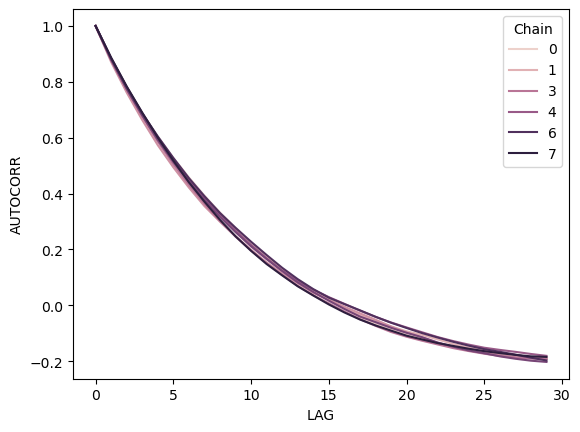

In [257]:
sample_eval.autocorrelation_plot()

In [267]:
def autocorrelation_singleparam(params_eval):
    max_lag = 30
    #to get normalized correlation
    params_chain_a = (params_eval- np.mean(params_eval)) / (np.std(params_eval) * len(params_eval))
    params_chain_b = (params_eval - np.mean(params_eval)) / np.std(params_eval)
    ac_param = correlate(params_chain_a, params_chain_b)
    half_idx = len(ac_param)//2
    ac_param = ac_param[half_idx:(half_idx + max_lag)]
    return ac_param

def calculate_autocorrelation(params_chains):
    AC = {'Burn-in' : [], 'Chain':[], 'LAG' : [],'#Burn-in': [], 'AUTOCORR': []}
    
    for chain in range(nr_chains):
        params_chain= params_chains[chain]

        ac = np.apply_along_axis(autocorrelation_singleparam, arr = params_chain, axis = 0)
        fig, axs = plt.subplots()
        for param in range(ac.shape[1]):
            df = pd.DataFrame(ac[:,param], columns = ['Samples'])
            ax = sns.lineplot(data = df, x = df.index, y = 'Samples', legend = False)
            ax.set_title(f'Chain {chain}')
        

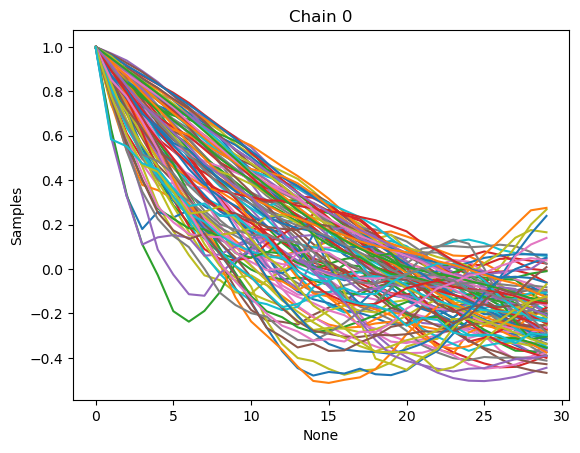

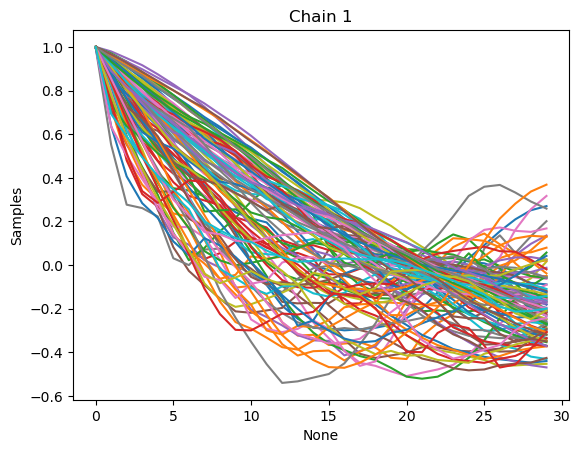

In [275]:
params_eval = filter_params(100, ckpt_paths, parameter_sizes)
calculate_autocorrelation(params_eval)

### Trace Plot

In [408]:
params_eval = filter_params(80, ckpt_paths, parameter_sizes, return_layer=True)

In [437]:
def trace_plot(params, nr_plotsamples):
    fig, axs = plt.subplots(ncols = 1, nrows=len(params), figsize = (10,20))      
    nr_chains = len(params)   
    
    for idx_param, params_layer in enumerate(params):
        params_filtered = pd.DataFrame({})
        nr_params_layer= params_layer.shape[2]
        for chain in range(nr_chains):
            params_layer_chain = pd.DataFrame(params_layer [chain], columns = [f'Param{i}' for i in range(nr_params_layer)])
            params_layer_chain = params_layer_chain.iloc[:nr_plotsamples]
            params_layer_chain['Sample'] = range(len(params_layer_chain))

            params_layer_chain_long = params_layer_chain.melt(id_vars = 'Sample', var_name = 'Param', value_name = 'Value')
            params_layer_chain_long['Chain'] = chain + 1
            params_filtered = pd.concat((params_filtered, params_layer_chain_long))

        
        ax = sns.lineplot(data = params_filtered, x = 'Sample', y = 'Value', hue = 'Param', style = 'Chain', legend = False, ax = axs[idx_param])
        ax.set_title(param_names[idx_param])
        ax.set_xlabel('')
    plt.tight_layout()
    plt.show()

In [1]:
trace_plot(params_eval, 1000)

NameError: name 'trace_plot' is not defined

### Check Convergence

In [447]:
# All parameters

params_eval = filter_params(200, ckpt_paths, parameter_sizes, return_layer=False)

sample_eval = HMCSampleEvaluation(params_eval, 4096, hidden_sizes, reduce = False)
rhat = sample_eval.split_rhat(burnin = 0)
rhat_rn = sample_eval.split_rhat(burnin = 0, rank_normalized = True)

print(f'Parameter: Across all Parameters')
print(f'Split-RHAT:')
print(f'{np.mean(rhat)} +/- {np.std(rhat)}')
print(f'RN-Split-RHAT:' )
print(f'{np.mean(rhat_rn)} +/- {np.std(rhat_rn)}')

Parameter: Across all Parameters
Split-RHAT:
2.6976592540740967 +/- 0.8297192454338074
RN-Split-RHAT:
2.3819458949131316 +/- 0.5582329927793103


In [446]:
# for every layer

params_eval = filter_params(200, ckpt_paths, parameter_sizes, return_layer=True)

for idx, params in enumerate(params_eval):
    sample_eval = HMCSampleEvaluation(params, 4096, hidden_sizes, reduce = False)
    rhat = sample_eval.split_rhat(burnin = 0)
    rhat_rn = sample_eval.split_rhat(burnin = 0, rank_normalized = True)

    print('==============')
    print(f'Parameter: {param_names[idx]}')
    print(f'Split-RHAT:')
    print(f'{np.mean(rhat)} +/- {np.std(rhat)}')
    print(f'RN-Split-RHAT:' )
    print(f'{np.mean(rhat_rn)} +/- {np.std(rhat_rn)}')

Parameter: weight.0
Split-RHAT:
2.3381154537200928 +/- 0.36967042088508606
RN-Split-RHAT:
2.137915369280501 +/- 0.29380285696103775
Parameter: bias.0
Split-RHAT:
2.5076582431793213 +/- 0.45912110805511475
RN-Split-RHAT:
2.2592896826948827 +/- 0.34448651217701504
Parameter: weight.1
Split-RHAT:
4.388020038604736 +/- 0.631062388420105
RN-Split-RHAT:
3.4415009729858625 +/- 0.48064856870290756
Parameter: bias.1
Split-RHAT:
2.325714588165283 +/- 0.0
RN-Split-RHAT:
2.2013832112181566 +/- 0.0


### Check ESS

In [449]:
# All parameters

params_eval = filter_params(200, ckpt_paths, parameter_sizes, return_layer=False)

sample_eval = HMCSampleEvaluation(params_eval, 4096, hidden_sizes, reduce = False)
sample_eval.calculate_autocorrelation()
ips = sample_eval.ips_per_chain(burnin = 0)
print(ips)


[4.892102860778288, 4.94809381873475, 5.176114525368577, 5.145115844999378, 4.9297233368459805, 5.015727985299385, 4.870517072550847, 5.085866956475132]
